<a href="https://colab.research.google.com/github/shwetapriya64/Sorghum-cultivar_identification/blob/main/sorghum_cultivar_efficientnet_b0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##import libraies
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from skimage import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0

%matplotlib inline

In [ ]:
#import training data
df_train = pd.read_csv('/kaggle/input/sorghum-id-fgvc-9/train_cultivar_mapping.csv',index_col = 'image')
df_train.head()

,cultivar
image,
2017-06-16__12-24-20-930.png,PI_257599
2017-06-02__16-48-57-866.png,PI_154987
2017-06-12__13-18-07-707.png,PI_92270
2017-06-22__13-18-06-841.png,PI_152651
2017-06-26__12-56-48-642.png,PI_176766


In [ ]:
#missing-values in training data 
df_train[df_train.cultivar.isna()]

,cultivar
image,
.DS_Store,NaN


In [ ]:
n_images = os.listdir('/kaggle/input/sorghum-id-fgvc-9/train_images')
len(n_images)

22193

In [ ]:
len(df_train)

22194

In [ ]:
df_train = df_train.loc[n_images]

In [ ]:
len(df_train)

22193

In [ ]:
df_train[df_train.cultivar.isna()]

,cultivar
image,


In [ ]:
df_train.cultivar.nunique()

100

In [ ]:
df_train.cultivar.value_counts()

PI_156393    298
PI_155760    282
PI_157030    272
PI_329299    269
PI_152771    262
            ... 
PI_152816    136
PI_181080    136
PI_152971    135
PI_213900    135
PI_257600    134
Name: cultivar, Length: 100, dtype: int64

In [ ]:
df_train.reset_index(inplace = True)

In [ ]:
#label-encoding of sorghum cultivars
encoder = preprocessing.LabelEncoder()
df_train['cultivar_label'] = encoder.fit_transform(df_train.cultivar)
df_train.head()


,image,cultivar,cultivar_label
0,2017-06-15__13-09-26-144.png,PI_145619,1
1,2017-06-26__11-39-54-016.png,PI_329301,89
2,2017-06-28__10-34-55-758.png,PI_152727,8
3,2017-06-16__12-24-48-376.png,PI_156178,34
4,2017-06-12__13-43-48-343.png,PI_154987,29


In [ ]:
df_train.drop('cultivar', axis = 1, inplace = True)

In [ ]:
df_train.head()

,image,cultivar_label
0,2017-06-15__13-09-26-144.png,1
1,2017-06-26__11-39-54-016.png,89
2,2017-06-28__10-34-55-758.png,8
3,2017-06-16__12-24-48-376.png,34
4,2017-06-12__13-43-48-343.png,29


In [ ]:
#Custom dataset for train data
class SorghumCultivar(Dataset):
    def __init__(self, label_data, path, transform):
        super().__init__()
        self.label_data = label_data.values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.label_data)
    
    def __getitem__(self, index):
        img_name,label = self.label_data[index]

        img_path = os.path.join(self.path, img_name)   
            
        image = io.imread(img_path)
        
        image = self.transform(image)
        
        return image, label

In [ ]:
#define transformations and train-val loaders
train_transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(256),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
])

val_transform =transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
])

In [ ]:
#train-val split
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df_train, stratify = df_train['cultivar_label'], test_size = 0.1)

In [ ]:
train_img_dir = '/kaggle/input/sorghum-id-fgvc-9/train_images'
train_data = SorghumCultivar(train, train_img_dir, train_transform)
valid_data = SorghumCultivar(valid, train_img_dir, val_transform )

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# Hyper parameters
num_epochs = 12
num_classes = 100
batch_size = 32
learning_rate = 0.001

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=1)

In [ ]:
#import pretrained efficientnet b0
model=models.efficientnet_b0(pretrained=True)
model=nn.DataParallel(model)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

DataParallel(
  (module): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activ

In [ ]:
#replace linear layer of the model

prev_params=list(model.module.parameters())

model.module.classifier=nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 100))
model

DataParallel(
  (module): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activ

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item()
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item()
        
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.069314 	Validation Loss: 0.041102
Epoch: 2 	Training Loss: 0.027539 	Validation Loss: 0.026258
Epoch: 3 	Training Loss: 0.017881 	Validation Loss: 0.018527
Epoch: 4 	Training Loss: 0.013147 	Validation Loss: 0.013354
Epoch: 5 	Training Loss: 0.010621 	Validation Loss: 0.017019
Epoch: 6 	Training Loss: 0.009261 	Validation Loss: 0.013071
Epoch: 7 	Training Loss: 0.007605 	Validation Loss: 0.014270
Epoch: 8 	Training Loss: 0.007125 	Validation Loss: 0.012259
Epoch: 9 	Training Loss: 0.006246 	Validation Loss: 0.011451
Epoch: 10 	Training Loss: 0.005930 	Validation Loss: 0.010342
Epoch: 11 	Training Loss: 0.005467 	Validation Loss: 0.010663
Epoch: 12 	Training Loss: 0.004857 	Validation Loss: 0.009998
CPU times: user 18h 23min 14s, sys: 18min 51s, total: 18h 42min 5s
Wall time: 9h 46min 46s


In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'last_state.pth')

Test Accuracy of the model: 91.44144144144144 %


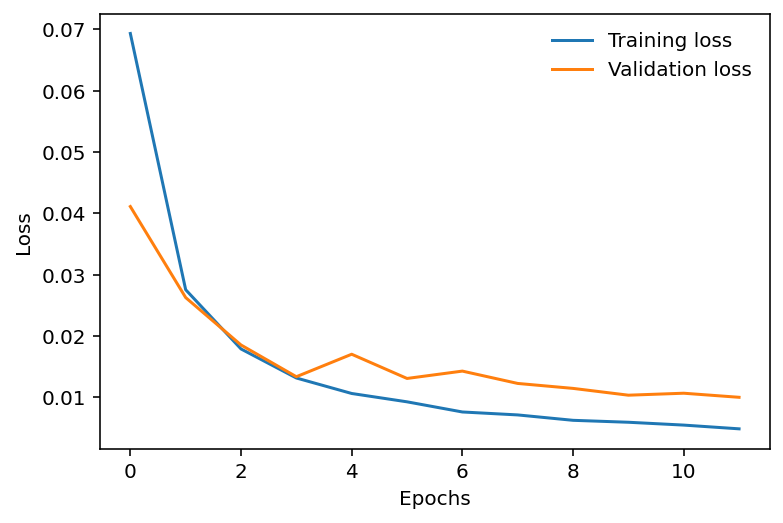

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
state_dict = torch.load('last_state.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test_df=pd.read_csv('/kaggle/input/sorghum-id-fgvc-9/sample_submission.csv').drop(columns="cultivar")
test_df

,filename
0,1000005362.png
1,1000099707.png
2,1000135300.png
3,1000136796.png
4,1000292439.png
...,...
23634,999578153.png
23635,999692877.png
23636,999756998.png
23637,999892248.png


In [ ]:
#Custom dataset for test data
class SorghumTest(Dataset):
    def __init__(self, test_path, test_df, transform):
        super().__init__()
        self.test_df = test_df
        self.test_path = test_path
        self.transform = transform

    def __len__(self):
        return len(self.test_df)
    
    def __getitem__(self, index):
        img_name = self.test_df.filename[index]

        img_path = os.path.join(self.test_path, img_name)   
            
        image = io.imread(img_path)
        
        image = self.transform(image)
        
        return image

In [ ]:
test_transform =transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
])


In [ ]:
test_img_dir = '/kaggle/input/sorghum-id-fgvc-9/test'
test_img = SorghumTest(test_path = test_img_dir,test_df = test_df,  transform = test_transform)
test_loader = DataLoader(dataset = test_img,batch_size=32,shuffle=False)

In [ ]:
from tqdm import tqdm


model.eval()

predictions = []

for image in tqdm(test_loader):
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        preds = outputs.detach().cpu()
        predictions.append(preds.argmax(1))

100%|██████████| 739/739 [49:09<00:00,  3.99s/it]


In [ ]:
predictions

['PI_329256',
 'PI_302252',
 'PI_181083',
 'PI_157030',
 'PI_156871',
 'PI_181080',
 'PI_155885',
 'PI_175919',
 'PI_276837',
 'PI_267573',
 'PI_253986',
 'PI_297155',
 'PI_153877',
 'PI_152751',
 'PI_157804',
 'PI_144134',
 'PI_217691',
 'PI_195754',
 'PI_175919',
 'PI_155516',
 'PI_156268',
 'PI_181080',
 'PI_181083',
 'PI_251672',
 'PI_156393',
 'PI_229841',
 'PI_152816',
 'PI_276837',
 'PI_175919',
 'PI_156487',
 'PI_273969',
 'PI_257600',
 'PI_179749',
 'PI_152965',
 'PI_251672',
 'PI_329326',
 'PI_154944',
 'PI_153877',
 'PI_152728',
 'PI_276837',
 'PI_19770',
 'PI_329310',
 'PI_145626',
 'PI_329326',
 'PI_180348',
 'PI_180348',
 'PI_302252',
 'PI_156871',
 'PI_145619',
 'PI_175919',
 'PI_329326',
 'PI_152728',
 'PI_175919',
 'PI_154988',
 'PI_154846',
 'PI_152961',
 'PI_156330',
 'PI_156487',
 'PI_255744',
 'PI_175919',
 'PI_145619',
 'PI_175919',
 'PI_152751',
 'PI_92270',
 'PI_196586',
 'PI_152923',
 'PI_152961',
 'PI_152694',
 'PI_156463',
 'PI_257599',
 'PI_152727',
 'PI_329

In [ ]:
temp = predictions[0]
for i in range(len(predictions) - 1):
    temp = torch.cat((temp, predictions[i+1]))

In [ ]:
df = pd.read_csv('/kaggle/input/sorghum-id-fgvc-9/train_cultivar_mapping.csv')

In [ ]:
df.head()

,image,cultivar
0,2017-06-16__12-24-20-930.png,PI_257599
1,2017-06-02__16-48-57-866.png,PI_154987
2,2017-06-12__13-18-07-707.png,PI_92270
3,2017-06-22__13-18-06-841.png,PI_152651
4,2017-06-26__12-56-48-642.png,PI_176766


In [ ]:
unique_cultivars = list(df['cultivar'].unique())
predictions = [unique_cultivars[x] for x in temp]

In [ ]:
test_df['cultivar'] = predictions

In [ ]:
test_df.head()

,filename,cultivar
0,1000005362.png,PI_329256
1,1000099707.png,PI_302252
2,1000135300.png,PI_181083
3,1000136796.png,PI_157030
4,1000292439.png,PI_156871


In [ ]:
len(test_df)

23639

In [ ]:
test_df.isna().sum()

filename    0
cultivar    0
dtype: int64

In [ ]:
test_df.to_csv("submission.csv",index=False)